# CLASSIFICATION-- FRAUD DETECTION

![image.png](attachment:image.png)

# Questions (Answers to the rest questions are implemented in the notebook)

1. What are the key factors that predict fraudulent customer?
2. Do these factors make sense? If yes, How? If not, How not?
3. What kind of prevention should be adopted while company update its infrastructure?
4. Assuming these actions have been implemented, how would you determine if they work?

# Answers

Answers are at the end of the notebook

# Installation

In [2]:
# !pip install xgboost
# !pip install -U imbalanced-learn
# !pip install --upgrade scipy
# !pip install threadpoolctl==3.1.0
# !pip install category_encoders

# Importation

In [3]:
# Data handling
import pandas as pd
import numpy as np
import threadpoolctl
# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )

# Statistics
from scipy import stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from collections import Counter

# balance data
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from statistics import stdev
from sklearn.model_selection import KFold

# Other packages
import os, pickle

import warnings
warnings.filterwarnings("ignore")

# Mounting Google Drive
from google.colab import drive  # Import for accessing Google Drive

# Unzipping files
import zipfile  # Import for extracting zip files

# Data Loading

In [4]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/datasets/rain.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV files in the zip folder
    file_path = zip_ref.extract('weatherAUS.csv', '/content/')

# Read the csv file from the url
data = pd.read_csv(file_path)

Mounted at /content/drive


In [5]:
# # Mount your Google Drive
# drive.mount('/content/drive')

# # Get the file path from Google Drive
# file_path = '/content/drive/MyDrive/Colab Notebooks/datasets/boating accidents.zip'

# # Unzip the file
# with zipfile.ZipFile(file_path, 'r') as zip_ref:
#     # Find the CSV files in the zip folder
#     file_path1 = zip_ref.extract('boating accidents/bard-2023-2023-ReleasableAccidents.csv', '/content/')
#     file_path2 = zip_ref.extract('boating accidents/bard-2023-2023-ReleasableDeaths.csv', '/content/')
#     file_path3 = zip_ref.extract('boating accidents/bard-2023-2023-ReleasableInjuries.csv', '/content/')
#     file_path4 = zip_ref.extract('boating accidents/bard-2023-2023-ReleasableVessels.csv', '/content/')

# # Read the csv file from the url
# accidents = pd.read_csv(file_path1)
# deaths = pd.read_csv(file_path2)
# injuries = pd.read_csv(file_path3)
# vessels = pd.read_csv(file_path4)

In [6]:
# !pip install ydata-profiling

In [7]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(accidents, title="Pandas Profiling Report")
# profile.to_notebook_iframe()

Confirming the dataset is same as in the research paper

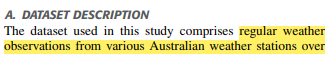

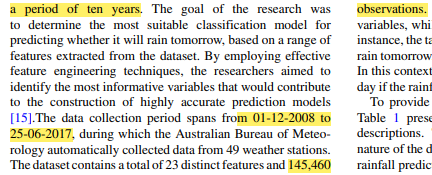

In [8]:
print("from:", data.Date.min(), "to:", data.Date.max())

from: 2007-11-01 to: 2017-06-25


In [9]:
print(len(data))

145460


since its the same length, that was probably a typing error

In [10]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


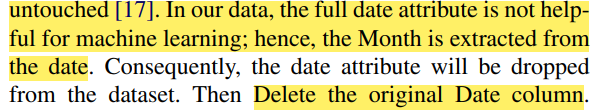

although I do not completely agree, there's nothing wrong with this approach. So let's follow the paper to a T

In [11]:
data['Date'] = pd.to_datetime(data['Date'])

In [12]:
data['Month'] = data['Date'].dt.month

In [13]:
data.drop('Date', inplace=True, axis=1)

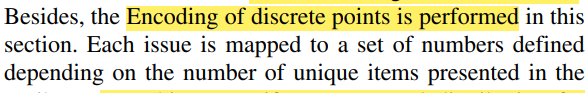

refering to the screenshot above, we'll encode the categoric variables here

In [14]:
# categoric = [col for col in data.columns if data[col].dtype == 'object']
# print("categoric_cols:", categoric)

In [15]:
# print("categoric_col", "-", "num_unique_values")
# for col in categoric:
#     print(col, "-", data[col].nunique())

In [16]:
# data['WindGustDir'].unique()

ordinal encoding is suitable for variables that have a meaningful order, like small, medium, large. Directions like North, East, West, South do not have a specific order.

therefore, let us use one-hot encoder for them since it treats direction as independent, which fits the nature of these variables.

same applies for location

as for "RainToday" and "RainTomorrow", we'll encode "yes" as 1 and "no" as 0.

In [17]:
# data['RainToday'] = data['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
# data['RainTomorrow'] = data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

In [18]:
# categoric.remove("RainTomorrow")
# categoric.remove("RainToday")

In [19]:
# # calling our encoder
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first")
# # setting output to DataFrame
# encoder.set_output(transform="pandas")
# # encoding our data
# cat_encoded = encoder.fit_transform(data[categoric])

In [20]:
# numeric = [col for col in data.columns if data[col].dtype in ['int32', 'int64', 'float64']]
# print("numeric_cols:", numeric)

In [21]:
# data = pd.concat([cat_encoded, data[numeric]], axis=1)

In [22]:
# # Quantile Transformation
# quantile_transformer = QuantileTransformer(output_distribution='normal')
# train['num_orders_quantile'] = quantile_transformer.fit_transform(train[['num_orders']].values)

In [23]:
# # Set up the figure and axes
# plt.figure(figsize=(12, 6))

# # Original Distribution
# plt.subplot(1, 2, 1)  # Adjusted to 1 row, 2 columns
# plt.hist(train['num_orders'], bins=30, color='blue', alpha=0.5)
# plt.title('Original Distribution')
# plt.xlabel('num_orders')
# plt.ylabel('Frequency')

# # Quantile Transformed Distribution
# plt.subplot(1, 2, 2)  # Adjusted to 1 row, 2 columns
# plt.hist(train['num_orders_quantile'], bins=30, color='green', alpha=0.5)
# plt.title('Quantile Transformed')
# plt.xlabel('Transformed num_orders')
# plt.ylabel('Frequency')

# # Adjust layout
# plt.tight_layout()

# # Show plot
# plt.show()


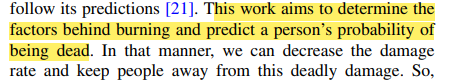

this work was obviously copied from somewhere cuz this project has nothing to do with burning. Researchers do this a lot so I'm not mad at it.

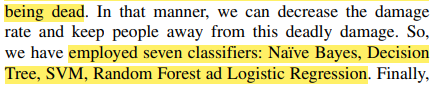

it's good you learn how all of these work so I took the liberty of searching for articles here on medium that simply explain how each model works. Exphasis on "simply", cuz I don't like needless confusion, haha.

decision tree is my favorite, but dont tell the researcher I said that. Our little secret haha.

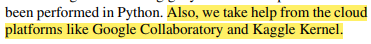

you all know that anything kaggle is a trigger for me, lol. Let's ignore it and use only google colab.

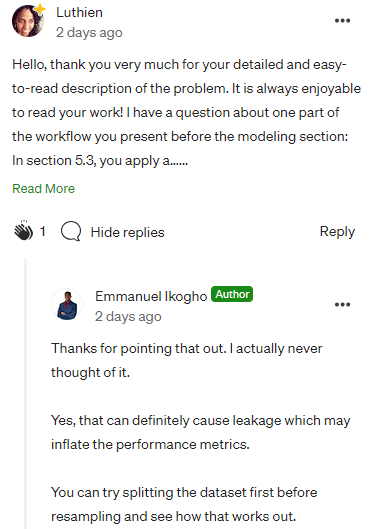

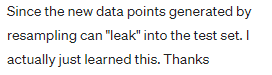

Outliers for each attribute are presented using the boxplot function.

Text(0.5, 1.0, 'Box Plot of Variables')

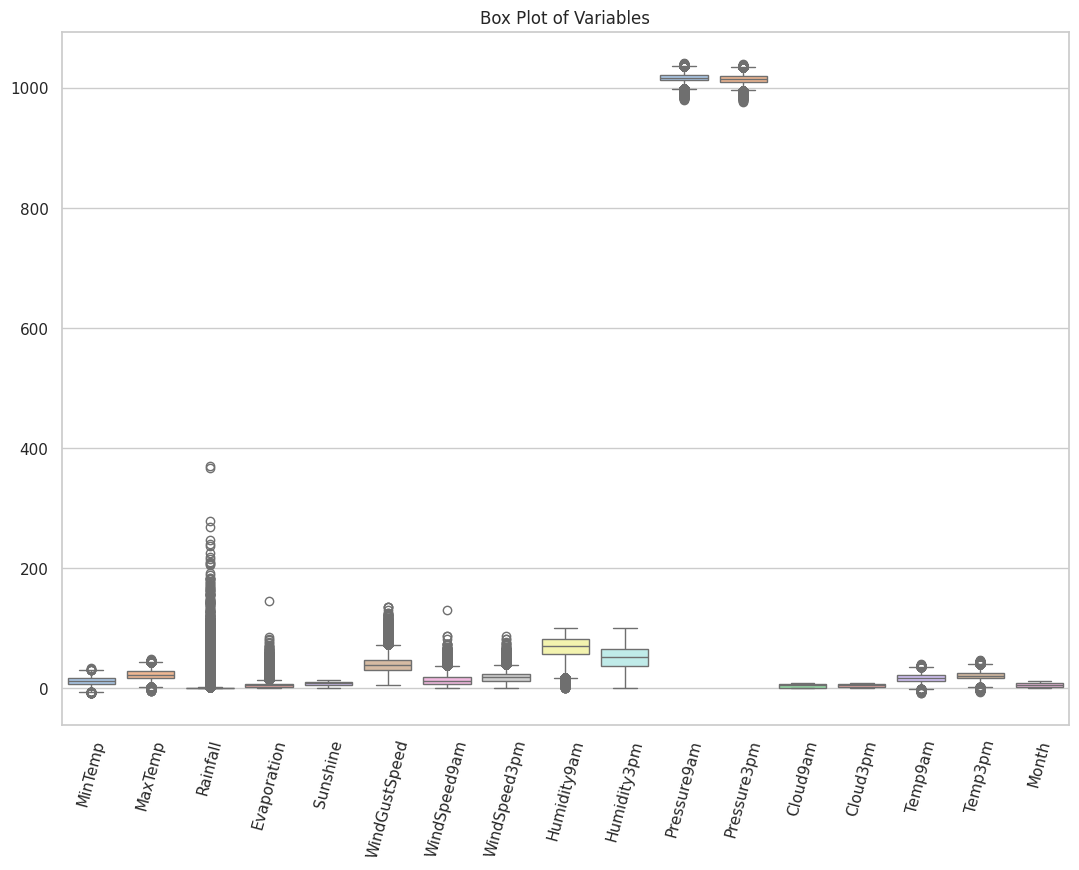

In [30]:
sns.set(style="whitegrid")

sns.boxplot(data=data, palette="pastel")  # Choose a color palette

# Customize the plot further (adjust as needed)
plt.xticks(rotation=75)  # Rotate x-axis labels
# plt.xlabel("Variables")
# plt.ylabel("Values")
plt.title("Box Plot of Variables")

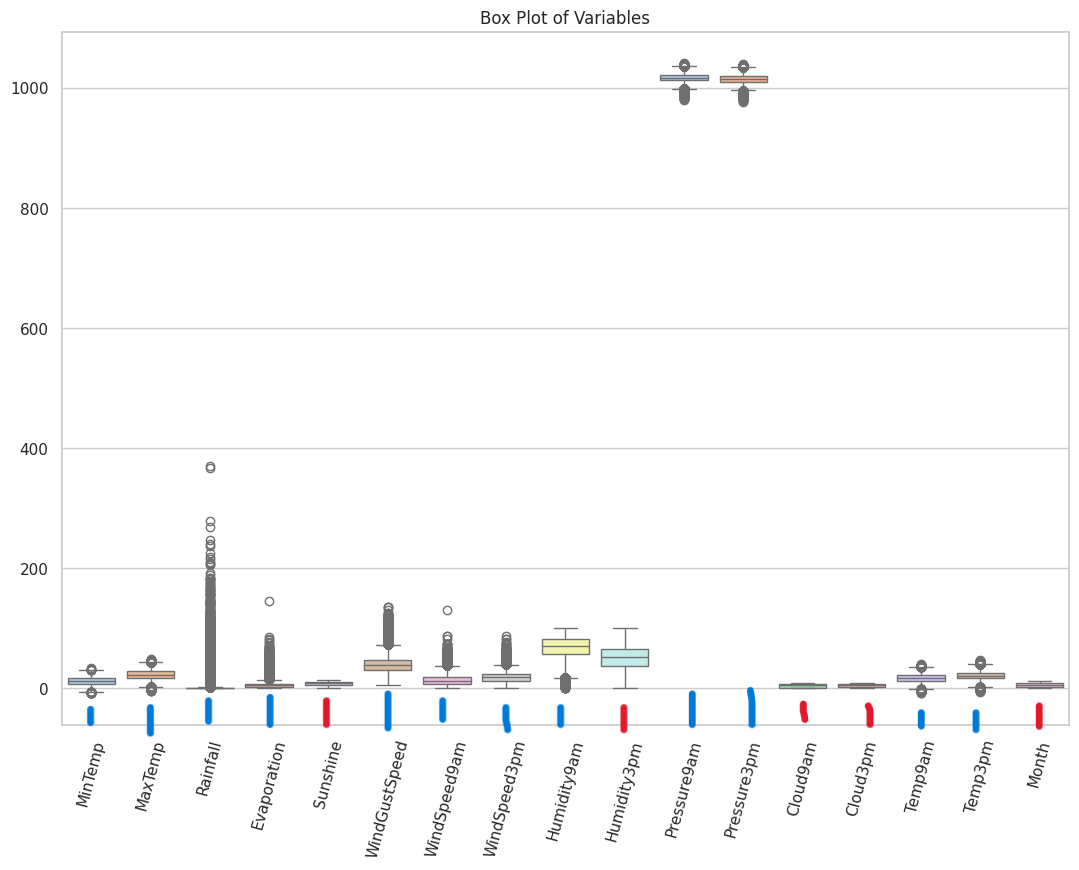

almost all the variables have outliers except those I've marked red do not have outliers

so let us create a list of numeric columns and remove those without outliers so we can focus on the rest

In [1]:
numeric = [col for col in data.columns if data[col].dtype in ['int32', 'int64', 'float64']]
numeric.remove('Sunshine')
numeric.remove('Humidity3pm')
numeric.remove('Cloud9am')
numeric.remove('Cloud3pm')
numeric.remove('Month')

NameError: name 'data' is not defined

creating histograms to visually assess
whether the distributions exhibit normalcy or skewness.

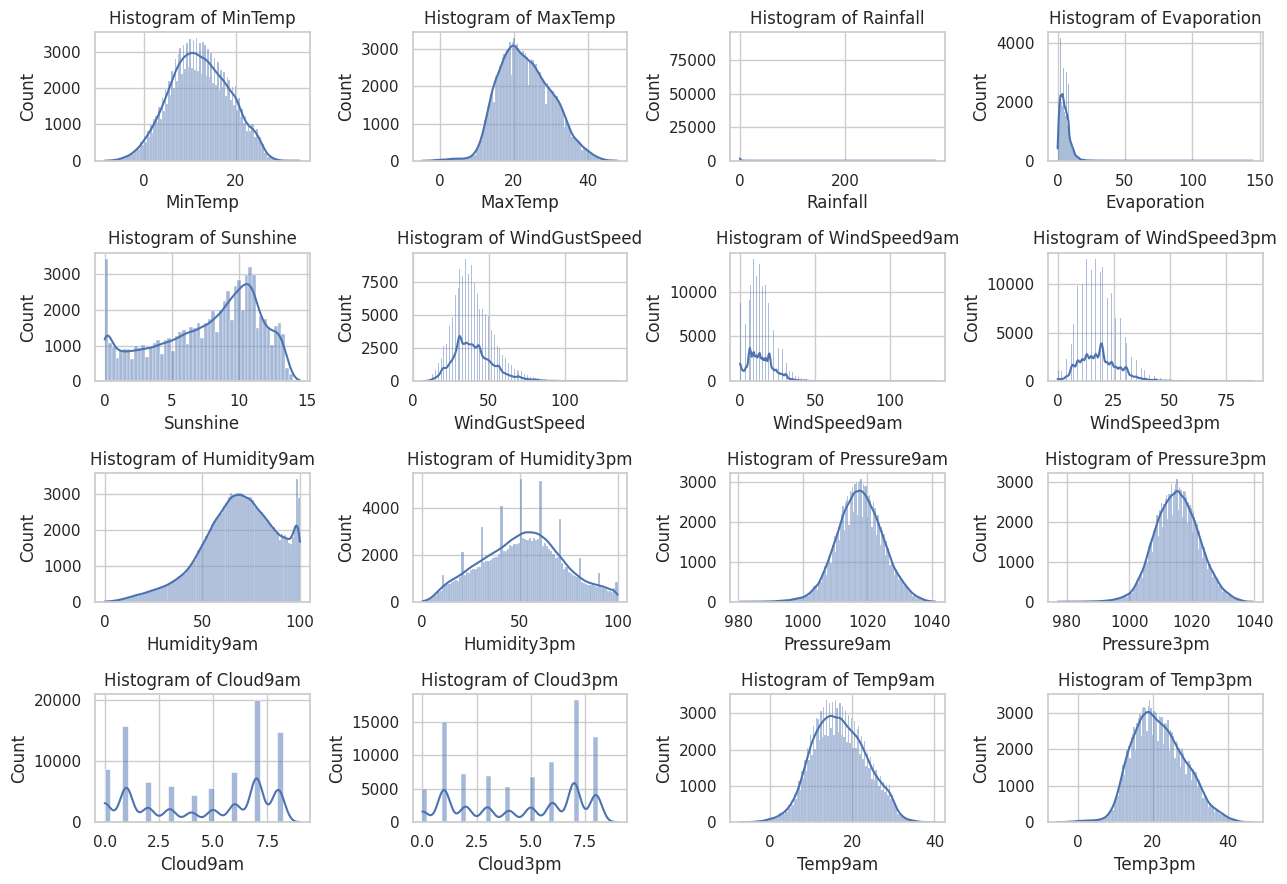

In [38]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(data[numeric].columns) / 4)), ncols=4)
for i, column in enumerate(data[numeric].columns):
    ax = axes.flatten()[i]
    sns.histplot(data=data, x=column, kde=True, ax=ax)

plt.tight_layout()
plt.show()

In [25]:
m

NameError: name 'm' is not defined

# Exploratory Data Analysis

Rename the columns for better readability.

In [ ]:
data['isMerchant'] = data['cust_dest'].apply(lambda x: 1 if x.startswith('M') else 0)

In [ ]:
data.shape

In [ ]:
# summary of the dataframe
data.info()

In [ ]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(col, data[col].nunique())

cust_orig and cust_dest are unique for each transaction, so we can drop them.

In [ ]:
data.drop(columns=['cust_orig', 'cust_dest'], inplace=True)

In [ ]:
data.describe()

check for outliers only in the columns that shouldn't have outliers.

In [ ]:
# Check of outliers by applying the IQR method checking
df = data.drop(['trans_type', 'time_step', 'isFraud', 'isFlaggedFraud', 'isMerchant'], axis=1)

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
IQR
((df < (Q1-1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any()


The results above showed there are outliers, but these outliers are probably because of fraudulent transactions.

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the boxplot
df.boxplot()

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()

**Outlier Removal Tradeoff:**
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect

**The Tradeoff**: The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower performance

In [ ]:
# Check if outliers still exist in the columns
outliers_exist = False

for col in df.columns.tolist():
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Modify the values in the col to be within the range
    df[col] = df[col].clip(lower_bound, upper_bound)

    # Check if outliers exist in the col
    if (df[col] < lower_bound).any() or (df[col] > upper_bound).any():
        outliers_exist = True
        print(f"Outliers still exist in '{col}'.")

## Bivariate Analysis

In [ ]:
# Apply logarithmic transformation to 'trans_amt' to handle skewness
df = data
df['log_trans_amt'] = np.log1p(df['trans_amt'])  # Using log1p to avoid log(0)

# Create a plot with the transformed data
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='log_trans_amt', hue='isFraud', multiple='stack', alpha=0.5)
plt.xlabel('Log of Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.show()
data.drop('log_trans_amt', axis=1, inplace=True)

In [ ]:
fig = plt.figure(figsize= (10,8))

sns.countplot(data = data,
              x = 'trans_type',
              hue = 'isFraud')
plt.show()

## Multivariate Analysis

let's see for other categories

In [ ]:
# Setup figure
cols = 2
rows = 1
fig = plt.figure(figsize= (10,8))

# Plotting
for i, col in enumerate(['isMerchant', 'isFlaggedFraud']):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(x=data[col], hue='isFraud', data=data, ax=ax)
    plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

In [ ]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
numeric.remove('isFraud')
categoric = [col for col in data.columns if data[col].dtype == 'object']

### multi-collinearity

In [ ]:
# correlation heatmap df
correlation = data[numeric].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

In [ ]:
# correlation heatmap df
correlation = data[numeric].corr()

# Get column pairs with correlation > 0.5
high_corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.5:
            high_corr_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))

# Check if there are high correlation pairs
if high_corr_pairs:
    # Print column pairs with correlation > 0.5 and their correlation values
    for pair in high_corr_pairs:
        print(pair[0], "-", pair[1], "Correlation:", pair[2])
else:
    print("No high correlation columns")

these variables have a very high correlation

In [ ]:
# so we will drop one from each pair
data.drop(columns=['old_orig_bal', 'old_dest_bal'], inplace=True)

In [ ]:
# Define your color palette
color = ['#40DFEF', '#E78EA9']

# Create the box plot
sns.boxplot(data=data, x='isFraud', y='time_step', palette=color)

# Display the plot
plt.show()

This means that on average,

fraudulent transactions were made at later hours, or at a greater time step (hrs)

## Hypothesis validation

## Statistical Normality Tests

Normality tests are used to determine if a dataset is normally distributed about the mean value. it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.

on the other hand, Gaussian distribution is a continuous probability distribution with symmetrical sides around its center. Its mean, median and mode are equal.

Popular normality tests - D’Agostino’s K^2, Shapiro-Wilk, Anderson-Darling .

### D’Agostino’s K^2 Test

In [ ]:
# get a list of numerical columns in our dataset
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

# loop over each numerical column and test for normality
for col in data[numeric]:
    stat, p = stats.normaltest(data[col])
    # print('Statistics=%.5f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'looks Gaussian (fail to reject H0) for this column: {col}')
    else:
        print(f'does not look Gaussian (reject H0) for this column: {col}')


# Feature Processing & Engineering

## Drop Duplicates

In [ ]:
data.shape

In [ ]:
data.duplicated().sum()

let's have a closer look at the duplicates

In [ ]:
data['trans_type'].unique()

In [ ]:
dup = data.loc[data.duplicated(),:]
dup.head(22)

these transactions look fraudulent, but they are not.

money was payed, but there is no trace of it in either sending or receiving accounts

so we'll leave them. Remember, we have to be careful as to avoid deleting useful training information.

these do not look like duplicates, since the amount is different for each record. So we'll ignore

## Creating new features

## Impute Missing Values

In [ ]:
data.isnull().sum()

In [ ]:
# Drop the missing rows
# data = data.dropna()

In [ ]:
df = data
X = df.drop('isFraud', axis=1)
y = df['isFraud']

## Data Imbalance Check

In [ ]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']
palette2 = ['#FF6347', '#008080', '#E50000', '#D2691E']

l1 = list(data['isFraud'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['No Fraud','isFraud'],
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('isFraud and No Fraud %');

plt.subplot(1,2,2)
ax = sns.countplot(data = data,
                   x='isFraud',
                   palette = palette,
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['No Fraud','isFraud'])

plt.title('isFraud and No Fraud')
plt.show()


Dataset is imbalanced. Fraudulent cases are only 0.13% of our data.

This means that a blind guess (on "No Fraud") would give us accuracy of 99%

Therefore, we can't use Accuracy Score to choose our model

what to do to solve this issue:

1. We could use stratified splitting during train-test split (split the dataset in a way that preserves the same proportions of examples in each class.)
2. We could be extra careful when dealing with outliers (we can delete meaningull information).
3. Resampling Techniques — Oversample minority class or Undersample majority class.

In [ ]:
#Oversampling the minority class (the churn customers)
ros = RandomOverSampler(random_state=0)
X_new,y_new= ros.fit_resample(X, y)
# X_new,y_new= X, y

print("After Random Over Sampling Of Minor Class Total Samples are :", len(y_new))
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))

Now our data is balanced

# Dataset Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.20, random_state = 42)

In [ ]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

# Features Encoding

In [ ]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
numeric.remove('isFraud')
print("numeric_cols:", numeric)
print("categoric_cols:", categoric)
categoric = [col for col in data.columns if data[col].dtype == 'object']

In [ ]:
# calling our encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop="first")
# setting output to DataFrame
encoder.set_output(transform="pandas")
# encoding our data
X_catEncoded_train = encoder.fit_transform(X_train[categoric])
X_catEncoded_test = encoder.transform(X_test[categoric]) # encoding our test data

# Features Scaling


In [ ]:
Scaler = StandardScaler().fit(X_train[numeric]).set_output(transform="pandas")

X_numScaled_train = Scaler.transform(X_train[numeric])
X_numScaled_test = Scaler.transform(X_test[numeric])

In [ ]:
X_train = pd.concat([X_numScaled_train, X_catEncoded_train], axis=1)
X_test = pd.concat([X_numScaled_test, X_catEncoded_test], axis=1)

# Machine Learning Modeling


## 1.  Logistic Regression

### Create the Model

In [ ]:
model= LogisticRegression()

### Train the Model

In [ ]:
model=model.fit(X_train, y_train)


###  Predict on the test dataset

In [ ]:
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]


### Model Evaluation

In [ ]:
r_lgt= recall_score(y_test, pred)
print("recall_score : ", r_lgt)

p_lgt= precision_score(y_test, pred)
print("precision_score :",p_lgt)

f1_lgt= f1_score(y_test, pred)
print("f1_score :", f1_lgt)

f2_lgt = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score :", f2_lgt)

A_lgt= accuracy_score(pred, y_test)
print("accuracy_score :",A_lgt)

acu_lgt = roc_auc_score(pred, y_test)
print("ROC_AUC Score:",acu_lgt)


In [ ]:
# plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Logistic Regression ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

## 3. XGBoost Classifier

### Create the Model

In [ ]:
XG_model= XGBClassifier()

### Train the Model

In [ ]:
XG_model= XG_model.fit(X_train, y_train)

### Predict on the test dataset

In [ ]:
XG_pred = XG_model.predict(X_test)
XG_prob = XG_model.predict_proba(X_test)[:,1]

### Model Evaluation

In [ ]:
r_XG= recall_score(y_test, XG_pred)
print("recall_score : ", r_XG)

p_XG= precision_score(y_test, XG_pred)
print("precision_score :",p_XG)

f1_XG= f1_score(y_test, XG_pred)
print("f1_score :", f1_XG)

f2_XG = fbeta_score(y_test, XG_pred, beta=2, average='binary')
print("f2_score :", f2_XG)


A_XG= accuracy_score( y_test, XG_pred)
print("accuracy_score :",A_XG)

acu_XG = roc_auc_score(XG_pred, y_test)
print("ROC_AUC Score:",acu_XG)


In [ ]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, XG_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('XGBoost ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

##  6. DecisionTreeClassifier

### Create the Model

In [ ]:
dtmodel = DecisionTreeClassifier()

### Train the Model

In [ ]:
dtmodel = dtmodel.fit(X_train, y_train)

### Predict on the test dataset

In [ ]:
dt_pred = dtmodel.predict(X_test)
dt_prob = dtmodel.predict_proba(X_test)[:,1]

### Model Evaluation

In [ ]:
r_dt= recall_score(y_test, dt_pred)
print("recall_score : ", r_dt)

p_dt= precision_score(y_test, dt_pred)
print("precision_score :",p_dt)

f1_dt= f1_score(y_test, dt_pred)
print("f1_score :", f1_dt)

f2_dt = fbeta_score(y_test, dt_pred, beta=2, average='binary')
print("f2_score :", f2_dt)


A_dt= accuracy_score( y_test, dt_pred)
print("accuracy_score :", A_dt)

acu_dt = roc_auc_score(dt_pred, y_test)
print("ROC_AUC Score:",acu_dt)

In [ ]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, dt_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('dt ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

# Models comparison

False Negatives:

False negatives occur when the model incorrectly predicts that a patient does not have the disease when, in reality, they do.
The consequence of a false negative is that the patient may not receive necessary treatment or intervention, potentially leading to undetected or untreated health issues. This can result in the progression of the disease, worsening health outcomes, and possibly even life-threatening situations if the disease is serious.

Given that false negatives are more costly in this medical diagnosis classification project, and I've balanced the classes using Random Over Sampler, it's advisable to prioritize metrics that focus on minimizing false negatives.

In this context, the most appropriate metric to use would be recall or the F2 score. Both of these metrics emphasize the minimization of false negatives, making them suitable for scenarios where the cost of missing positive cases (i.e., false negatives) is high.

In [ ]:
compare_models = ['Logistic Regression', 'XGBClassifier', 'DecisionTreeClassifier']

data = {
    'Accuracy': [A_lgt, A_XG, A_dt],
    'Recall': [r_lgt, r_XG, r_dt],
    'Precision': [p_lgt, p_XG, p_dt],
    'f1_score': [f1_lgt, f1_XG, f1_dt],
    'f2_score': [f2_lgt, f2_XG, f2_dt],
    'ROC_AUC': [acu_lgt, acu_XG, acu_dt],
    'Description': ['', 'best model', '']
}
result=pd.DataFrame(data=data, index=compare_models)
result

In a fraud detection project, it is generally more important to prioritize false negatives over false positives. This is because false negatives mean that fraudulent transactions go undetected, leading to potential financial losses and other negative consequences.

False positives, while inconvenient, do not result in direct financial loss and can be managed with additional verification steps.

Given this context, the best metrics to focus on are Recall and f2_score. Recall measures the ability to identify actual fraud cases correctly (minimizing false negatives), while the f2_score places more emphasis on recall compared to precision.


Based on the above metrics, **decisionTree Classifier is the best model** for this fraud detection project as it has the highest recall (0.99) and a high f2_score (0.99), indicating it is effective in detecting fraudulent transactions while minimizing false negatives.

In the context of fraud detection, ROC_AUC is important because it gives a holistic view of the model's performance across all classification thresholds.

Based on the ROC_AUC values and previously discussed metrics (recall and f2_score), decisionTree Classifier stands out as the best model for this fraud detection project with the highest ROC_AUC (0.99).

# k-Fold cross validation

## decisionTree Classifier (Best Model)

In [ ]:
dt_fold = KFold(n_splits = 5,shuffle=True)
# Define custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

score = cross_val_score(dtmodel, X_train, y_train, cv=dt_fold, scoring=f2_scorer, error_score="raise")
dt_cv_score = score.mean()
dt_cv_stdev = stdev(score)
print('Cross Validation f2 scores are: {}'.format(score))
print('Average Cross Validation f2 score: ', dt_cv_score)
print('Cross Validation f2 standard deviation: ', dt_cv_stdev)

after evaluation with KFold cross validation,

our best model maintains its high performance

#### for exporting the ml assets (scaler, model, encoder) for deployment

In [ ]:
# with open('model.pkl', 'wb') as f:
#     pickle.dump(dt_tuned, f)

# Using Confusion Matrix For Predictions

# DecisionTree Classifier

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
y_pred_dt = dtmodel.predict(X_test)

cm = confusion_matrix(y_test, y_pred_dt, labels=dtmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=dtmodel.classes_)
disp.plot(ax=ax)
plt.show()

Based on confusion matrix:

1. There are 438 transactions predicted to have fraud when they actually don't, this can be corrected with investigation within the company
2. There are 0 transactions predicted to not have fraud when they actually do, this is more important

# Feature Importance

# DecisionTreeClassifier

In [ ]:
fimp = pd.Series(data=dtmodel.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')


# Answers

1. **What are the key factors that predict fraudulent customer?**

   Based on the feature importance, the key factors are:
   - New/old origin balance (multi-collinearity)
   - New/old destination balance (multi-collinearity)
   - Time_step (hours)
   - Transaction amount
   - Transaction type

2. **Do these factors make sense? If yes, How? If not, How not?**

   Yes, these factors make sense. Large and unusual changes in balances, significant transaction amounts, and certain transaction types are common indicators of fraudulent activity. The timing of transactions can also reveal suspicious patterns.

3. **What kind of prevention should be adopted while the company updates its infrastructure?**

   The company should adopt robust security measures, such as:
   - Enhanced authentication methods (e.g., two-factor authentication)
   - Real-time monitoring and alert systems for suspicious transactions
   - Regular security audits and updates
   - Implementation of machine learning models to detect anomalies

4. **Assuming these actions have been implemented, how would you determine if they work?**

   To determine if the implemented actions are effective, you should:
   - Monitor the reduction in fraudulent transactions and compare it to historical data
   - Analyze metrics such as the number of false positives and false negatives
   - Conduct periodic reviews and updates of the security measures
   - Gather feedback from customers regarding their experience with the new security measures
